In [87]:
using OneTest
using LinearAlgebra
using Plots

In this notebook, I am preparing to do temporal analysis on College Scorecard data by considering a continuous-time form of the price update. For simplicity, I will assume that $A$ doesn't change, which is true if there are no ties among the cutoffs and $\alpha$ is sufficiently small.

In [105]:
C = 6
m = Market(C)
Γ = sum(m.gamma)
p = equilibrium(m)
Ā, sort_order = demandmatrix(m, p)
A = zeros(C, C)
A[sort_order, sort_order] = Ā

6×6 UpperTriangular{Float64, Matrix{Float64}}:
 -1.0   0.506329   0.21296   0.0889659   0.0534287   0.0349853
   ⋅   -0.506329   0.21842   0.091247    0.0547987   0.0358823
   ⋅     ⋅        -0.43138   0.136718    0.0821062   0.0537633
   ⋅     ⋅          ⋅       -0.316931    0.088311    0.0578263
   ⋅     ⋅          ⋅         ⋅         -0.278645    0.0704794
   ⋅     ⋅          ⋅         ⋅           ⋅         -0.252937

In [15]:
demand(m, p) ≈ A*p + m.gamma ./ sum(m.gamma)

true

We know $$\frac{\partial D}{\partial p} = A$$
That is, each row of $A$ is the gradient of $D_c$ wrt the cutoff vector.

We also have the tatonnement update $$\frac{d}{dt} p = \alpha (D(t) - q)= \alpha (Ap(t) + \frac{\gamma}{\Gamma} - q )$$
This is the ODE we are trying to solve, given $p(0)$. 

Rearranging, 
$$\frac{1}{\alpha}p' - A p = \frac{\gamma}{\Gamma} - q $$

<!-- We want to find the demand function $D(t)$ that solves the ODE

$$\frac{d}{dt} D(t) = \frac{\partial D}{\partial p} \frac{d}{dt} p = \alpha A (Ap(t) + \frac{\gamma}{\Gamma} - q )$$

with the initial conditions $p(0)$ and $D(0)$. -->

Homogeneous solution: We have $p' = \alpha Ap$. Let $p(t) = c y e^{\lambda_1 t}$ where $y, \lambda$ is an eigenpair of $\alpha A$. Then $p'(t) = c (\lambda y) e^{\lambda t}  = c (\alpha A y )e^{\lambda t} = \alpha A p(t)$.

In other words, $p$ is a linear combination of the eigenvalues of $\alpha A$. Put the eigenvectors in the columns of $Y$; then $p(t) = Y e^{\Lambda t} v$ for any $v$.  

Now we consider the forcing function, which is constant, so we guess $p(t) = u$ as our particular solution. 
$$ - A u = \frac{\gamma}{\Gamma} - q $$
or 
$$ u = - A^{-1}\left(\frac{\gamma}{\Gamma} - q  \right)$$
which we recognize as the closed-form expression for the equilibrium, except without the positive part operator.

Thus we have $p(t) = Y e^{\Lambda t} v - A^{-1}\left(\frac{\gamma}{\Gamma} - q  \right)$. Applying the initial condition, $$v = Y^{-1} \left[p(0) + A^{-1}\left(\frac{\gamma}{\Gamma} - q  \right)\right]$$
and $$p(t) = Y e^{\Lambda t} Y^{-1} \left[p(0) + A^{-1}\left(\frac{\gamma}{\Gamma} - q  \right)\right] - A^{-1}\left(\frac{\gamma}{\Gamma} - q  \right) $$

In [98]:
α = 0.1
Λ, Y = eigen(α * A)
Λ = Diagonal(Λ)
Z = inv(Y)
Ainv = inv(A)
A * Y ≈ Y * Λ

false

In [107]:
function cutoffs(t)
    b = Ainv * (m.gamma/Γ - m.capacities)
    return Y * exp(t*Λ) * Z * (p + b) - b
end

function cutoffs(T::Vector, p0)
    res = zeros(length(T), C)
    for (i, t) in enumerate(T)
        b = Ainv * (m.gamma/Γ - m.capacities)
        res[i, :] = Y * exp(t*Λ) * Z * (p0 + b) - b
    end
    return res
end

cutoffs (generic function with 3 methods)

In [110]:
p0 = equilibrium(m)

6-element Vector{Float64}:
 0.8079532993341454
 0.0
 0.053194459425666085
 0.0
 0.0
 0.32785312248569864

In [116]:
sort_order = sortperm(equilibrium(m))

6-element Vector{Int64}:
 2
 4
 5
 3
 6
 1

In [132]:
# Random cutoffs whose sort order agrees with the equilibrium
p0 = zeros(C)
p0[sort_order] = sort(rand(C))

6-element Vector{Float64}:
 0.044039940779192044
 0.059115634343289036
 0.14365154776374855
 0.163420873462083
 0.331939818266209
 0.7839665789609223

In [134]:
# Converges kind of to the equilibrium, but not perfectly because of positive part operation.
# Should converge exactly if sum capacities leq 1.

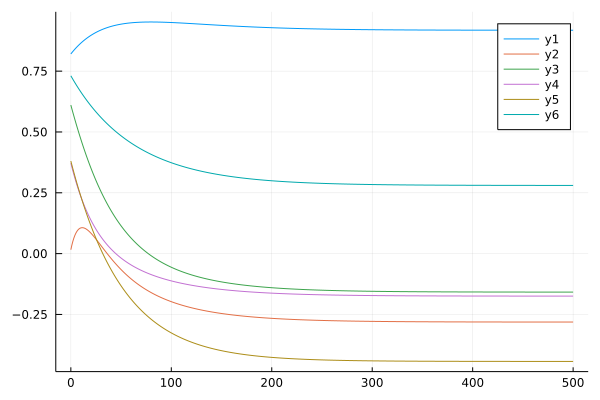

In [131]:
T = 0:500
P = cutoffs(collect(T), p0)

plot(T, P)

In [128]:
P[end, :] - equilibrium(m)

6-element Vector{Float64}:
  0.1101496073132916
 -0.2812795469376687
 -0.21136750565746745
 -0.17461932688146886
 -0.44311062313927047
 -0.04757694559152098